In [1]:
import os

In [2]:
from pathlib import Path
import os

path = Path(r"C:\Users\saibh\OneDrive\Documents\Kidney-Disease-Classification-Deep-Learning-Project\research")
os.chdir(path)

# Verify
print("Current Directory:", Path.cwd())


Current Directory: C:\Users\saibh\OneDrive\Documents\Kidney-Disease-Classification-Deep-Learning-Project\research


In [3]:
%pwd

'C:\\Users\\saibh\\OneDrive\\Documents\\Kidney-Disease-Classification-Deep-Learning-Project\\research'

In [4]:
os.chdir("../")

In [5]:
%pwd

'C:\\Users\\saibh\\OneDrive\\Documents\\Kidney-Disease-Classification-Deep-Learning-Project'

In [ ]:
os.environ["MLFLOW_TRACKING_URI"]="https://dagshub.com/saibharath2005/Kidney-Disease-Classification-MLflow-DVC.mlflow"
os.environ["MLFLOW_TRACKING_USERNAME"]="saibharath2005"
os.environ["MLFLOW_TRACKING_PASSWORD"]="your_password"

In [ ]:
## set MLFLOW_TRACKING_URI=https://dagshub.com/saibharath2005/Kidney-Disease-Classification-MLflow-DVC.mlflow

## set MLFLOW_TRACKING_USERNAME=saibharath2005

## set MLFLOW_TRACKING_PASSWORD="your_password"

In [8]:
import tensorflow as tf

In [9]:
model = tf.keras.models.load_model("artifacts/training/model.h5")

In [10]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class EvaluationConfig:
    path_of_model: Path
    training_data: Path
    all_params: dict
    mlflow_uri: str
    params_image_size: list
    params_batch_size: int

In [11]:
from CNNClassifier.constants import *
from CNNClassifier.utils.common import read_yaml, create_directories, save_json

In [12]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    
    def get_evaluation_config(self) -> EvaluationConfig:
        eval_config = EvaluationConfig(
            path_of_model="artifacts/training/model.h5",
            training_data="artifacts/data_ingestion/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
            mlflow_uri="https://dagshub.com/saibharath2005/Kidney-Disease-Classification-MLflow-DVC.mlflow",
            all_params=self.params,
            params_image_size=self.params.IMAGE_SIZE,
            params_batch_size=self.params.BATCH_SIZE
        )
        return eval_config




In [13]:
import tensorflow as tf
from pathlib import Path
import mlflow
import mlflow.keras
from urllib.parse import urlparse

In [14]:
class Evaluation:
    def __init__(self, config: EvaluationConfig):
        self.config = config

    
    def _valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.30
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )


    @staticmethod
    def load_model(path: Path) -> tf.keras.Model:
        return tf.keras.models.load_model(path)
    

    def evaluation(self):
        self.model = self.load_model(self.config.path_of_model)
        self._valid_generator()
        self.score = model.evaluate(self.valid_generator)
        self.save_score()

    def save_score(self):
        scores = {"loss": self.score[0], "accuracy": self.score[1]}
        save_json(path=Path("scores.json"), data=scores)

    
    def log_into_mlflow(self):
        mlflow.set_registry_uri(self.config.mlflow_uri)
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        
        with mlflow.start_run():
            mlflow.log_params(self.config.all_params)
            mlflow.log_metrics(
                {"loss": self.score[0], "accuracy": self.score[1]}
            )
            # Model registry does not work with file store
            if tracking_url_type_store != "file":

                # Register the model
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.keras.log_model(self.model, "model", registered_model_name="VGG16Model")
            else:
                mlflow.keras.log_model(self.model, "model")


In [15]:
try:
    config = ConfigurationManager()
    eval_config = config.get_evaluation_config()
    evaluation = Evaluation(eval_config)
    evaluation.evaluation()
    evaluation.log_into_mlflow()

except Exception as e:
   raise e

[2025-08-14 20:02:52,268: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-08-14 20:02:52,272: INFO: common: yaml file: params.yaml loaded successfully]
[2025-08-14 20:02:52,273: INFO: common: created directory at: artifacts]
Found 3732 images belonging to 4 classes.
234/234 [==============================] - 486s 2s/step - loss: 15.8619 - accuracy: 0.3025
[2025-08-14 20:10:59,453: INFO: common: json file saved at: scores.json]


2025/08/14 20:11:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


[2025-08-14 20:11:02,753: WARNING: save: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 14). These functions will not be directly callable after loading.]
INFO:tensorflow:Assets written to: C:\Users\saibh\AppData\Local\Temp\tmpdq5mw5pw\model\data\model\assets
[2025-08-14 20:11:03,298: INFO: builder_impl: Assets written to: C:\Users\saibh\AppData\Local\Temp\tmpdq5mw5pw\model\data\model\assets]


c:\Users\saibh\anaconda3\envs\pro\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Successfully registered model 'VGG16Model'.
2025/08/14 20:11:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: VGG16Model, version 1
Created version '1' of model 'VGG16Model'.


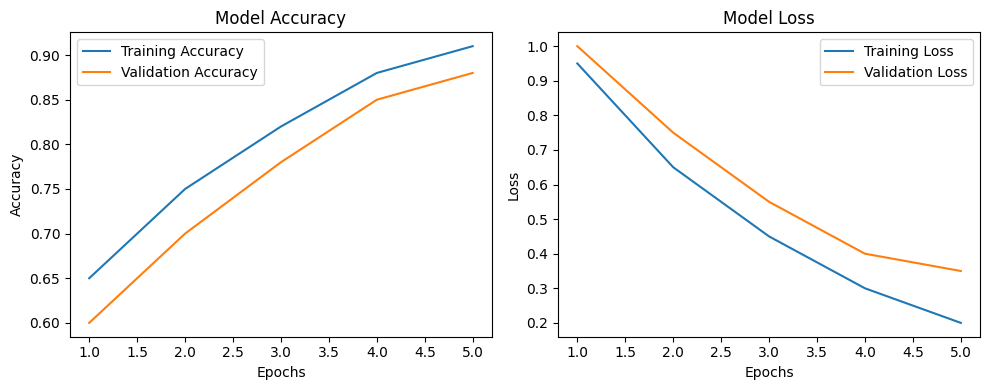

In [1]:
import matplotlib.pyplot as plt

# Example training history dictionary
history = {
    "accuracy": [0.65, 0.75, 0.82, 0.88, 0.91],
    "val_accuracy": [0.60, 0.70, 0.78, 0.85, 0.88],
    "loss": [0.95, 0.65, 0.45, 0.30, 0.20],
    "val_loss": [1.00, 0.75, 0.55, 0.40, 0.35]
}

epochs = range(1, len(history["accuracy"]) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history["accuracy"], label="Training Accuracy")
plt.plot(epochs, history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history["loss"], label="Training Loss")
plt.plot(epochs, history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.tight_layout()
plt.show()